### Most of the code provided below belongs to top kaggle authors of this competition 
### Reference
#### [FC Ensemble External Data (EffNet+DenseNet)](https://www.kaggle.com/code/atamazian/fc-ensemble-external-data-effnet-densenet)
#### [Computer Vision - Petals to the Metal🌻🌸🌹](https://www.kaggle.com/code/georgezoto/computer-vision-petals-to-the-metal)
#### [Flower Classification with TPUs - EDA and Baseline](https://www.kaggle.com/code/dimitreoliveira/flower-classification-with-tpus-eda-and-baseline)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow import keras
from kaggle_datasets import KaggleDatasets
import os
import seaborn as sns
import random
import math, re

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

K = keras.backend

tf.random.set_seed(42)
np.random.seed(42)

2022-05-19 01:32:24.116634: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-19 01:32:24.116807: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/04-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/15-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [2]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


### Set-up TPUs

In [3]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470


2022-05-19 01:32:30.237916: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-19 01:32:30.237978: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-19 01:32:30.238008: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (61afcea3989d): /proc/driver/nvidia/version does not exist
2022-05-19 01:32:30.241633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 01:32:30.265965: I tensorflow/core/platform/profile_utils/cpu_util

REPLICAS: 8


In [4]:
AUTO = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [512, 512]
CHANNELS = 3
BATCH_SIZE = 16 * REPLICAS
WARMUP_EPOCHS = 3
WARMUP_LEARNING_RATE = 1e-4 * REPLICAS
EPOCHS = 30
LEARNING_RATE = 3e-5 * REPLICAS
N_CLASSES = 104
ES_PATIENCE = 5

### Import the data

In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path("tpu-getting-started")
GCS_EFFNET_PATH = KaggleDatasets().get_gcs_path("efficientnet")

In [6]:
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 103

2022-05-19 01:32:38.276987: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-05-19 01:32:38.363518: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-05-19 01:32:38.440818: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


### Helper Functions

In [7]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=CHANNELS)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, CHANNELS]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed.
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files.
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

### Data Augmentation

In [8]:
def data_augment(image, label):
    crop_size = tf.random.uniform([], int(IMAGE_SIZE[0]*.7), IMAGE_SIZE[0], dtype=tf.int32)
        
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, lower=0, upper=2)

#     image = tf.image.random_saturation(image, lower=0, upper=2)
#     image = tf.image.random_contrast(image, lower=.8, upper=2)
#     image = tf.image.random_brightness(image, max_delta=.2)
#     image = tf.image.adjust_gamma(image, gamma=.6)

    image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
    image = tf.image.resize(image, size=[IMAGE_SIZE[0], IMAGE_SIZE[0]])

    return image, label

### Data Pipelines

In [9]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function creates a training dataset for model evaluations (w/o augmentation and repeat())
def get_training_dataset_preview(ordered=True):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_valid_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=True):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

### Some visualization functions

In [10]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
        # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 
                                'OK' if correct else 'NO', 
                                u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None, display_mismatches_only=False):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        if display_mismatches_only:
            if predictions[i] != label:
                subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
        else:        
            subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

def display_training_curves_v2(training, validation, learning_rate_list, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title, color='b')
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.', 'learning rate'])        
    
    ax2 = ax.twinx()
    ax2.plot(learning_rate_list, 'g-')
    ax2.set_ylabel('learning rate', color='g')

### EDA

In [11]:
ds_train = get_training_dataset_preview()
ds_valid = get_valid_dataset()
ds_test = get_test_dataset(ordered=True)

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.string)>


In [12]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
y_train = next(iter(ds_train.unbatch().map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy()

NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
y_valid = next(iter(ds_valid.unbatch().map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy()

NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
y_test = next(iter(ds_test.unbatch().map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy()

print('Dataset: {} training images, {} validation images, {} unlabeled test images'
      .format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


#### Some training data

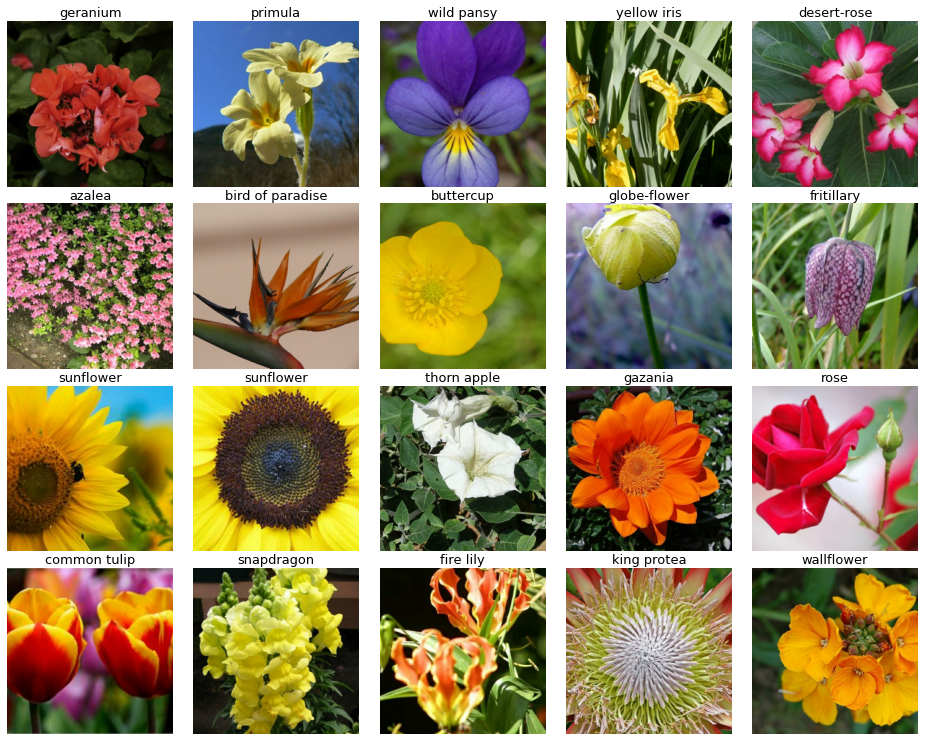

In [13]:
ds_iter = iter(ds_train.unbatch().batch(20))
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

#### Some validation data

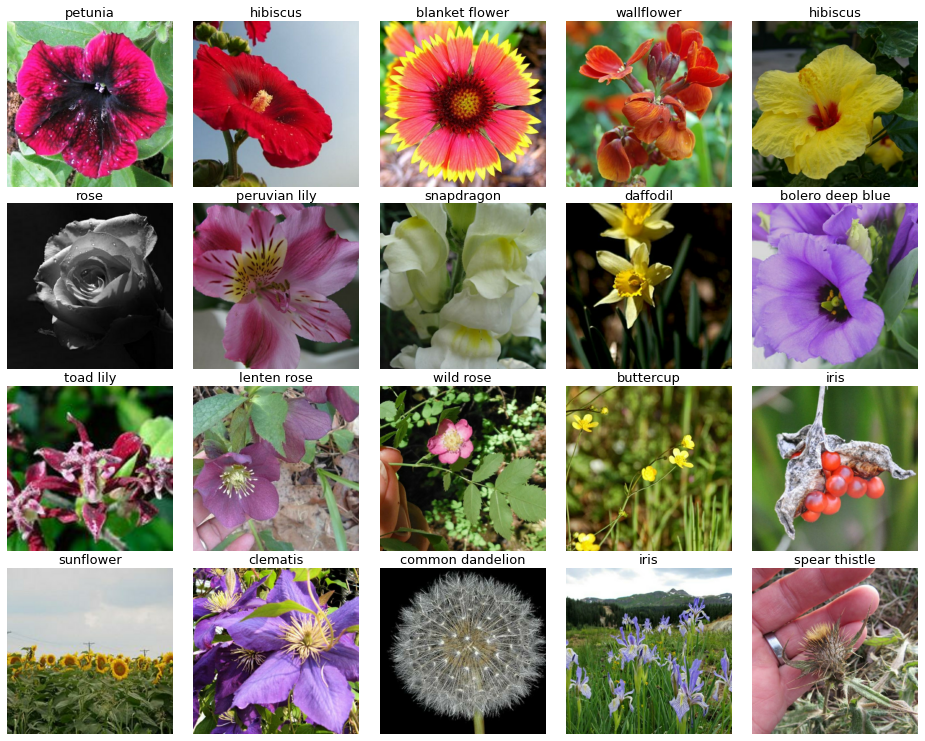

In [14]:
ds_iter = iter(ds_valid.unbatch().batch(20))
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

#### Some test data

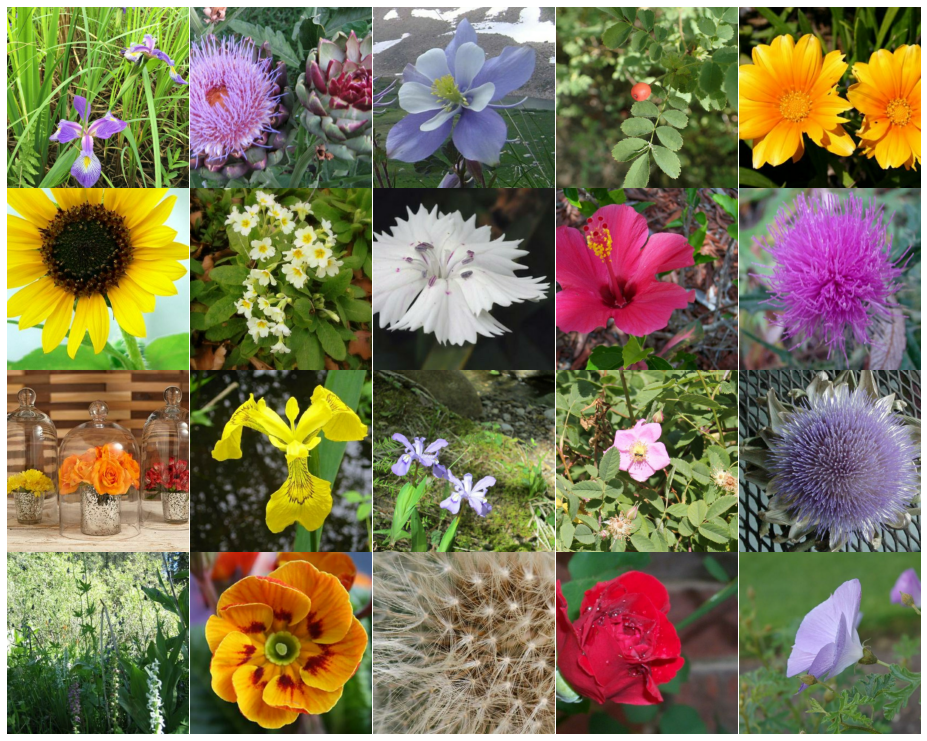

In [15]:
ds_iter = iter(ds_test.unbatch().batch(20))
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

## Classes distribution

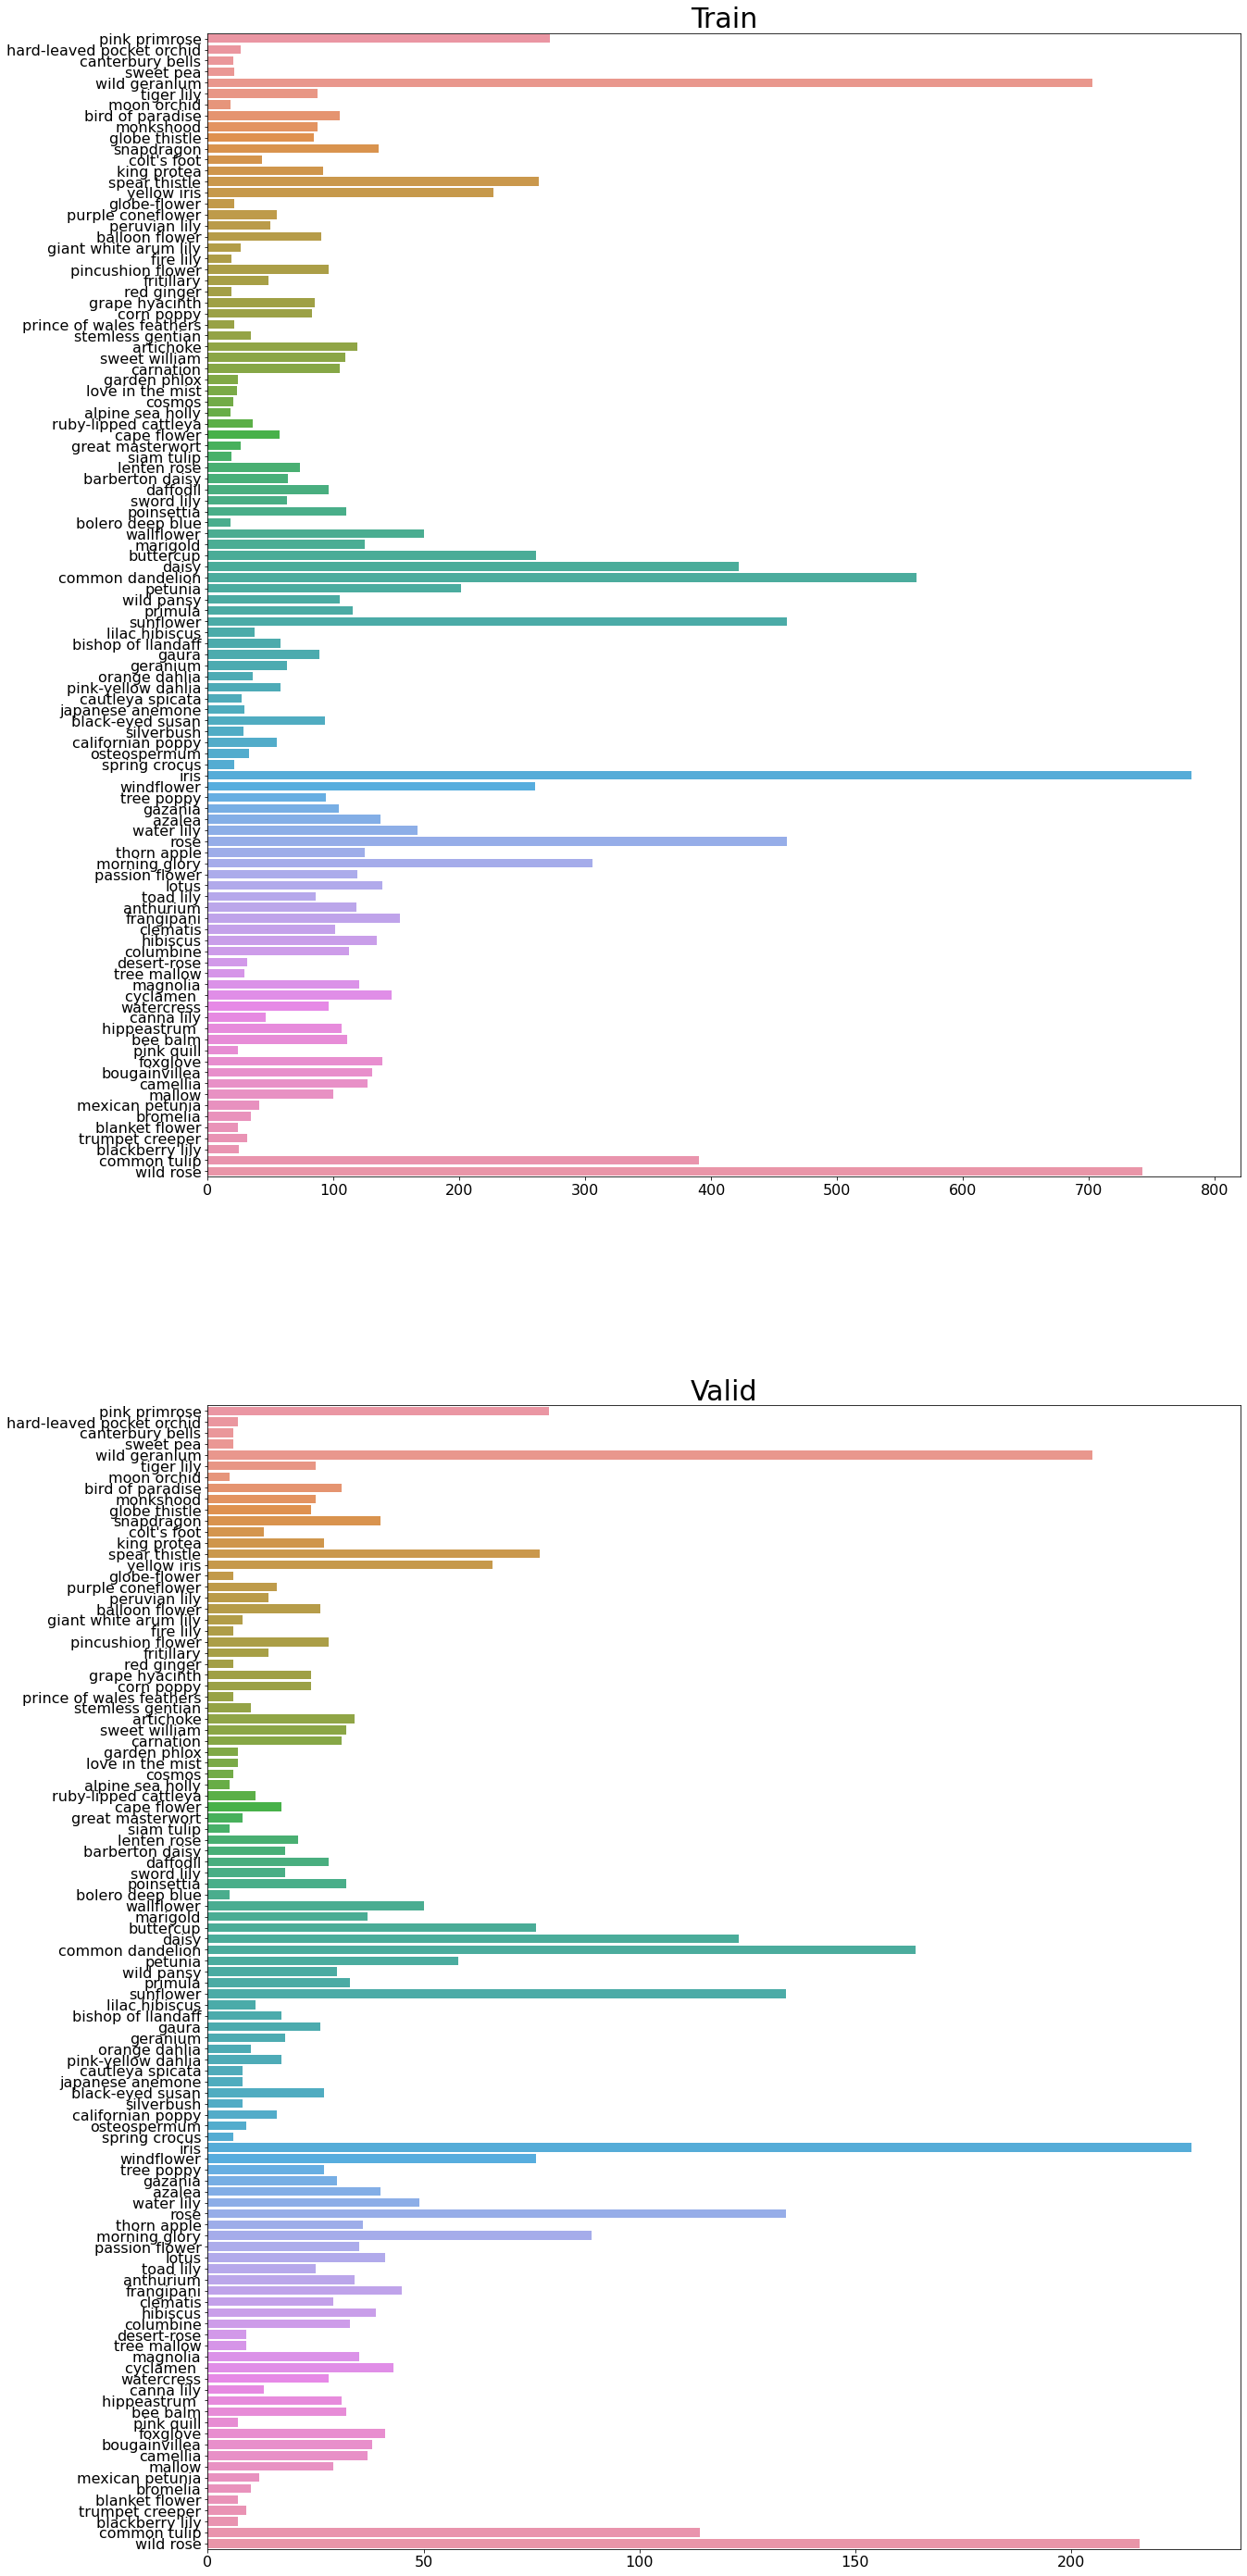

In [16]:
train_agg = np.asarray([[label, (y_train == index).sum()] for index, label in enumerate(CLASSES)])
valid_agg = np.asarray([[label, (y_valid == index).sum()] for index, label in enumerate(CLASSES)])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 50))

ax1 = sns.barplot(x=train_agg[..., 1].astype(np.int64), y=train_agg[..., 0], order=CLASSES, ax=ax1)
ax1.set_title('Train', fontsize=30)
ax1.tick_params(labelsize=16)

ax2 = sns.barplot(x=valid_agg[..., 1].astype(np.int64), y=valid_agg[..., 0], order=CLASSES, ax=ax2)
ax2.set_title('Valid', fontsize=30)
ax2.tick_params(labelsize=16)

In [17]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [ 43 102  67 ...  48  48  12]


2022-05-19 01:33:24.466074: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 151, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652924004.461697834","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 151, Output num: 0","grpc_status":3}


In [18]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U'))

Test data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Test data IDs: ['6ef2473d3' '954d0fe63' '2a0dc41cd' ... '53ef32294' '8846a7457' 'cd27460a9']


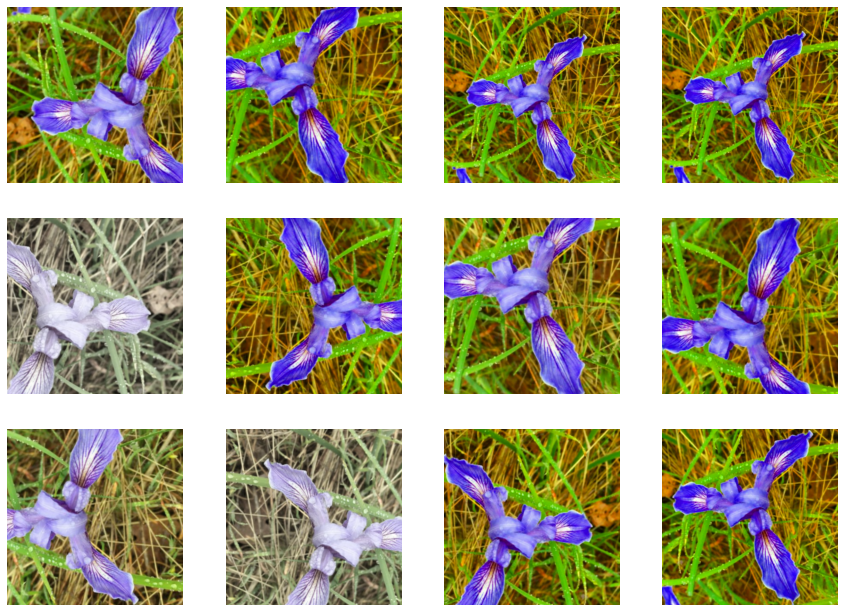

In [19]:
row = 3
col = 4
all_elements = get_training_dataset().unbatch()
one_element = tf.data.Dataset.from_tensors(next(iter(all_elements)))

augmented_element = one_element.repeat().map(data_augment).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

## Time to define the Model

In [20]:
!pip install --quiet efficientnet
import efficientnet.tfkeras as efn

In [21]:
# Tansfer Learning from Keras docs using Functional API

def create_model_effnet(input_shape, N_CLASSES):
    base_model = efn.EfficientNetB6(weights='/kaggle/input/efficientnet/efficientnet-b6_noisy-student_notop.h5', 
                                    include_top=False,
                                    input_shape=input_shape)
    base_model.trainable = False
    
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(N_CLASSES, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs)
    return model

In [22]:
# # Transfer Learning from "Flower Classification with TPUs - EDA and Baseline"

# def create_model_effnet(input_shape, N_CLASSES):
#     base_model = efn.EfficientNetB6(weights='/kaggle/input/efficientnet/efficientnet-b6_noisy-student_notop.h5', 
#                                     include_top=False,
#                                     input_shape=input_shape)
#     base_model.trainable = False
    
#     model = keras.models.Sequential([
#         base_model,
#         keras.layers.GlobalAveragePooling2D(),
#         keras.layers.Dense(N_CLASSES, activation="softmax")
#     ])
    
#     return model

### Warm-up top layers of the model

In [23]:
with strategy.scope():
    model = create_model_effnet((*IMAGE_SIZE, CHANNELS), N_CLASSES)

warmup_optimzier = keras.optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE)

model.compile(loss="sparse_categorical_crossentropy",
             optimizer=warmup_optimzier,
             metrics=["sparse_categorical_accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
efficientnet-b6 (Functional) (None, 16, 16, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               239720    
Total params: 41,199,856
Trainable params: 239,720
Non-trainable params: 40,960,136
_________________________________________________________________


In [24]:
checkpoint_warmup = tf.keras.callbacks.ModelCheckpoint(
    filepath="warmup_model.h5",
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [25]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model.fit(x=get_training_dataset(), 
                    validation_data=ds_valid, 
                    epochs=WARMUP_EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    callbacks=[checkpoint_warmup], 
                    verbose=2)

Epoch 1/3
99/99 - 77s - loss: 2.6011 - sparse_categorical_accuracy: 0.4688 - val_loss: 1.4823 - val_sparse_categorical_accuracy: 0.6878


2022-05-19 01:35:54.341038: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 51636, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652924154.340897499","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 51636, Output num: 0","grpc_status":3}


Epoch 2/3
99/99 - 29s - loss: 1.3514 - sparse_categorical_accuracy: 0.7076 - val_loss: 1.0021 - val_sparse_categorical_accuracy: 0.7834
Epoch 3/3
99/99 - 29s - loss: 1.0154 - sparse_categorical_accuracy: 0.7738 - val_loss: 0.8094 - val_sparse_categorical_accuracy: 0.8241


### Fine-tune whole model

Creating a learning rate scheduler

30 total epochs and 99 steps per epoch
Learning rate schedule: 1e-08 to 0.00024 to 1.72e-06


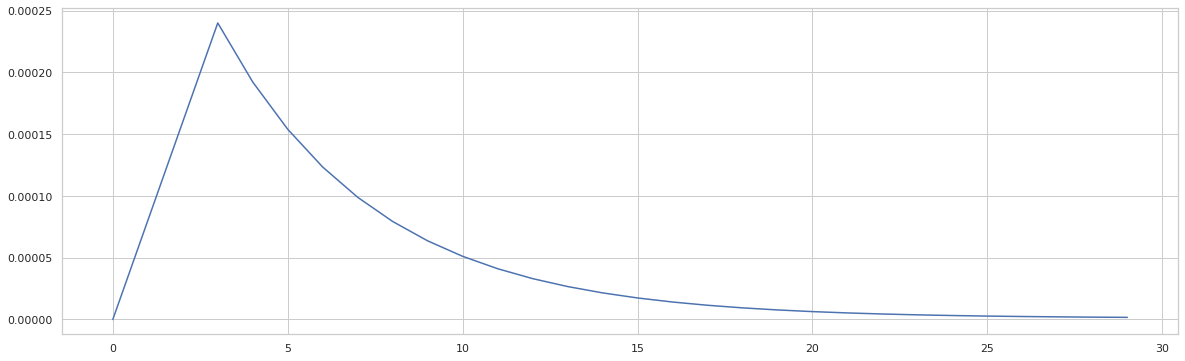

In [26]:
LR_START = 1e-8
LR_MIN = 1e-6
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{EPOCHS} total epochs and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

In [27]:
for layer in model.layers:
    layer.trainable = True

In [28]:
# Checkpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="full_model.h5",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=ES_PATIENCE,
    mode='min',
    restore_best_weights=True
)

# Learning rate schedule callback
lr_callback = keras.callbacks.LearningRateScheduler(lrfn, verbose=0)

In [29]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(loss="sparse_categorical_crossentropy",
             optimizer=optimizer,
             metrics=["sparse_categorical_accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
efficientnet-b6 (Functional) (None, 16, 16, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               239720    
Total params: 41,199,856
Trainable params: 40,975,424
Non-trainable params: 224,432
_________________________________________________________________


In [30]:
history = model.fit(x=get_training_dataset(), 
                    validation_data=ds_valid, 
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    callbacks=[checkpoint, early_stopping, lr_callback], 
                    verbose=2)

Epoch 1/30
99/99 - 207s - loss: 0.8962 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.8063 - val_sparse_categorical_accuracy: 0.8249


2022-05-19 01:40:37.247168: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 92929, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652924437.246075454","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 92929, Output num: 0","grpc_status":3}


Epoch 2/30
99/99 - 64s - loss: 0.4264 - sparse_categorical_accuracy: 0.8884 - val_loss: 0.2718 - val_sparse_categorical_accuracy: 0.9337
Epoch 3/30
99/99 - 64s - loss: 0.2278 - sparse_categorical_accuracy: 0.9384 - val_loss: 0.3077 - val_sparse_categorical_accuracy: 0.9208
Epoch 4/30
99/99 - 64s - loss: 0.2144 - sparse_categorical_accuracy: 0.9389 - val_loss: 0.2755 - val_sparse_categorical_accuracy: 0.9359
Epoch 5/30
99/99 - 64s - loss: 0.1079 - sparse_categorical_accuracy: 0.9680 - val_loss: 0.2877 - val_sparse_categorical_accuracy: 0.9375
Epoch 6/30
99/99 - 64s - loss: 0.0460 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.2658 - val_sparse_categorical_accuracy: 0.9464
Epoch 7/30
99/99 - 64s - loss: 0.0339 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.2576 - val_sparse_categorical_accuracy: 0.9494
Epoch 8/30
99/99 - 64s - loss: 0.0170 - sparse_categorical_accuracy: 0.9957 - val_loss: 0.2494 - val_sparse_categorical_accuracy: 0.9547
Epoch 9/30
99/99 - 64s - loss: 0.0094 - s

### Model evaluation

In [31]:
X_train = ds_train.map(lambda image, label: image)
train_probs = model.predict(X_train)
train_pred = np.argmax(train_probs, axis=-1)

X_valid = ds_valid.map(lambda image, label: image)
valid_probs = model.predict(X_valid)
valid_pred = np.argmax(valid_probs, axis=-1)

2022-05-19 01:57:00.727329: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 195693, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652925420.727117766","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 195693, Output num: 0","grpc_status":3}


In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, valid_pred, target_names=CLASSES))

                           precision    recall  f1-score   support

            pink primrose       1.00      0.96      0.98        79
hard-leaved pocket orchid       1.00      1.00      1.00         7
         canterbury bells       1.00      1.00      1.00         6
                sweet pea       1.00      0.67      0.80         6
            wild geranium       0.97      0.99      0.98       205
               tiger lily       0.85      0.88      0.86        25
              moon orchid       1.00      1.00      1.00         5
         bird of paradise       1.00      0.94      0.97        31
                monkshood       0.89      1.00      0.94        25
            globe thistle       0.92      0.96      0.94        24
               snapdragon       1.00      0.82      0.90        40
              colt's foot       1.00      1.00      1.00        13
              king protea       0.96      0.96      0.96        27
            spear thistle       0.97      0.99      0.98     

In [33]:
print(classification_report(y_train, train_pred, target_names=CLASSES))

                           precision    recall  f1-score   support

            pink primrose       1.00      1.00      1.00       272
hard-leaved pocket orchid       1.00      1.00      1.00        26
         canterbury bells       1.00      1.00      1.00        20
                sweet pea       1.00      1.00      1.00        21
            wild geranium       1.00      1.00      1.00       703
               tiger lily       1.00      1.00      1.00        87
              moon orchid       1.00      1.00      1.00        18
         bird of paradise       1.00      1.00      1.00       105
                monkshood       1.00      1.00      1.00        87
            globe thistle       1.00      1.00      1.00        84
               snapdragon       1.00      1.00      1.00       136
              colt's foot       1.00      1.00      1.00        43
              king protea       1.00      1.00      1.00        92
            spear thistle       1.00      1.00      1.00     

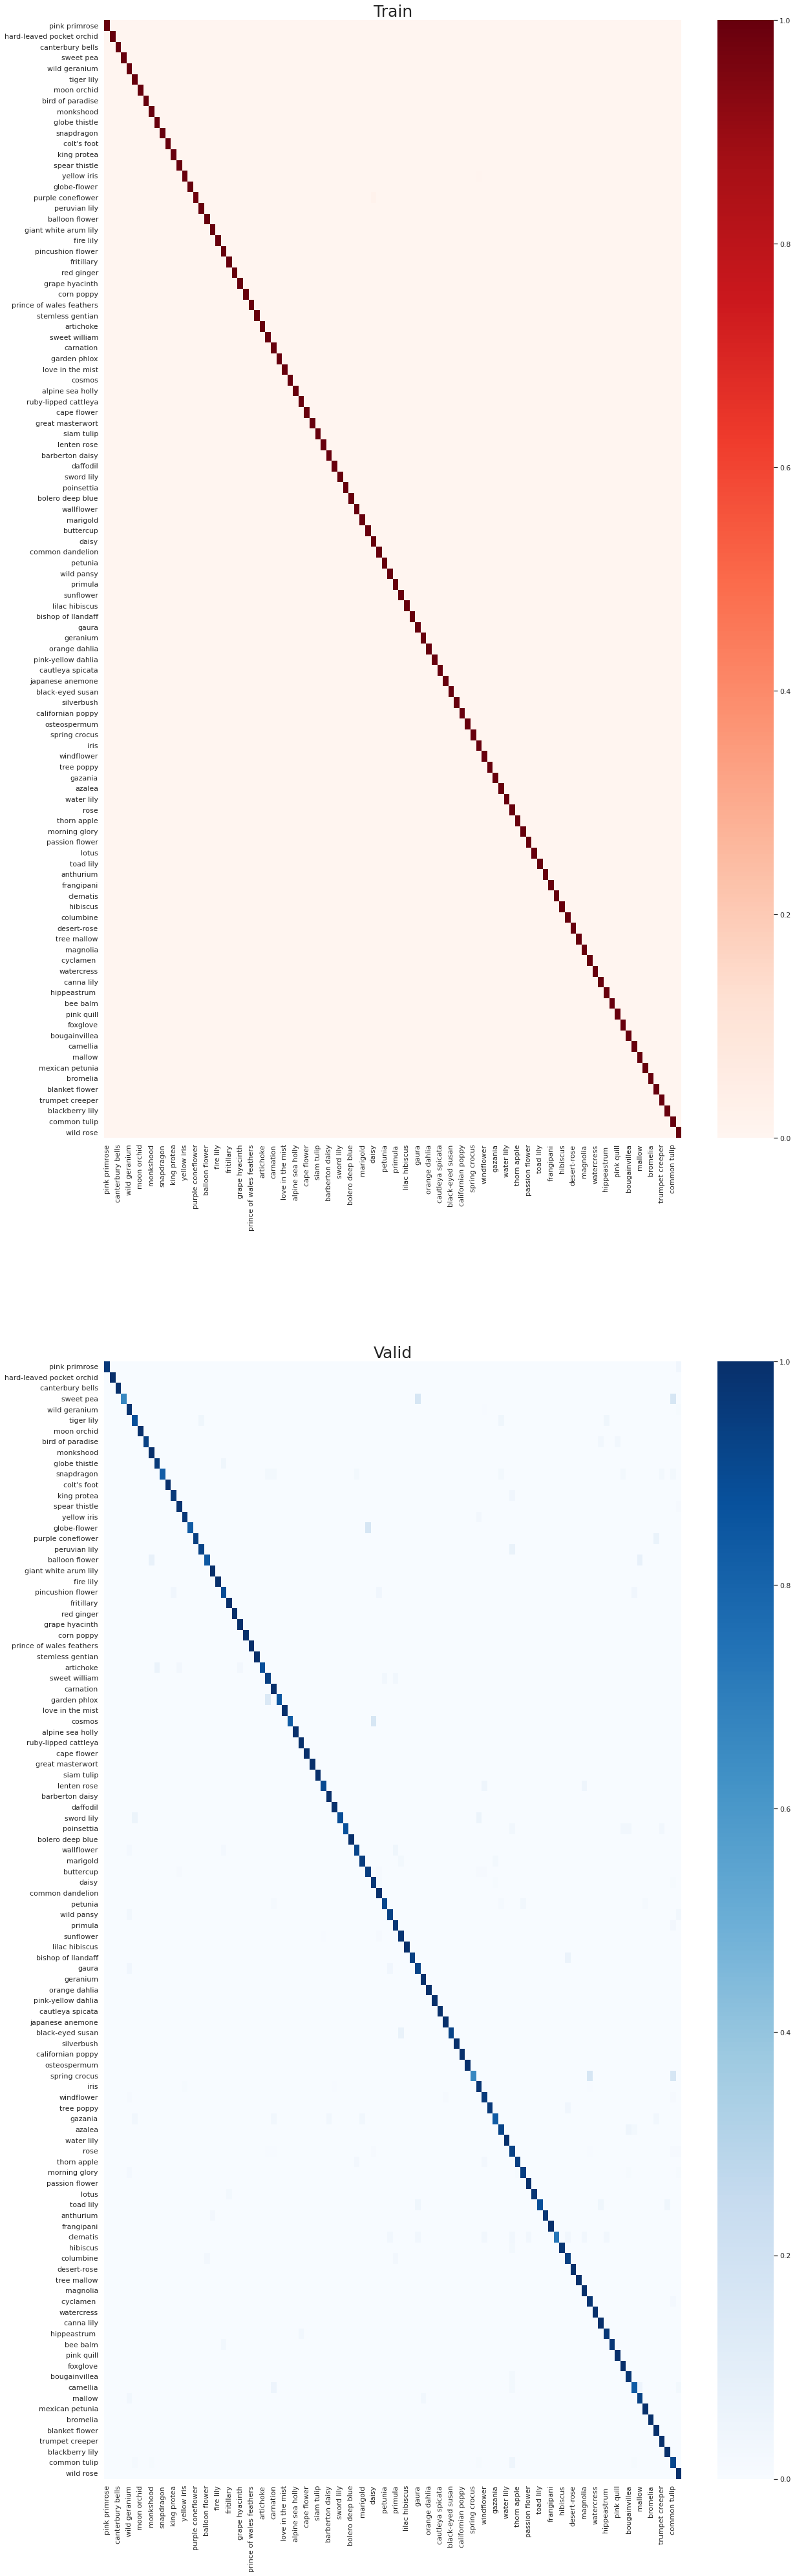

In [34]:
from sklearn.metrics import confusion_matrix

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,70))

train_mx = confusion_matrix(y_train, train_pred, labels=range(len(CLASSES)))
train_mx = (train_mx.T / train_mx.sum(axis=1)).T
train_df_mx = pd.DataFrame(train_mx, index=CLASSES, columns=CLASSES)
ax1 = sns.heatmap(train_df_mx, cmap="Reds", ax=ax1)
ax1.set_title("Train", fontsize=25)

valid_mx = confusion_matrix(y_valid, valid_pred, labels=range(len(CLASSES)))
valid_mx = (valid_mx.T / valid_mx.sum(axis=1)).T
valid_df_mx = pd.DataFrame(valid_mx, index=CLASSES, columns=CLASSES)
ax2 = sns.heatmap(valid_df_mx, cmap="Blues", ax=ax2)
ax2.set_title("Valid", fontsize=25)

plt.show()

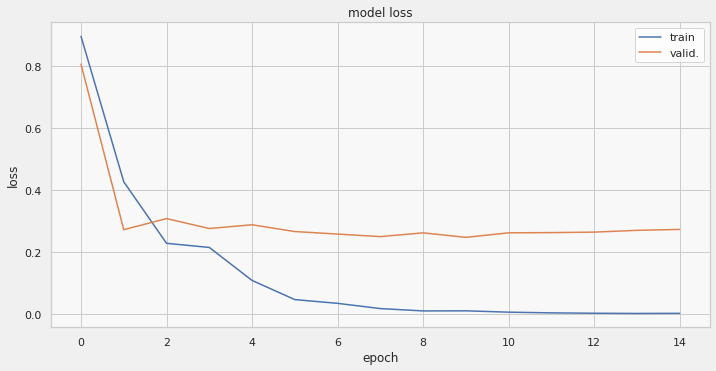

In [35]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)

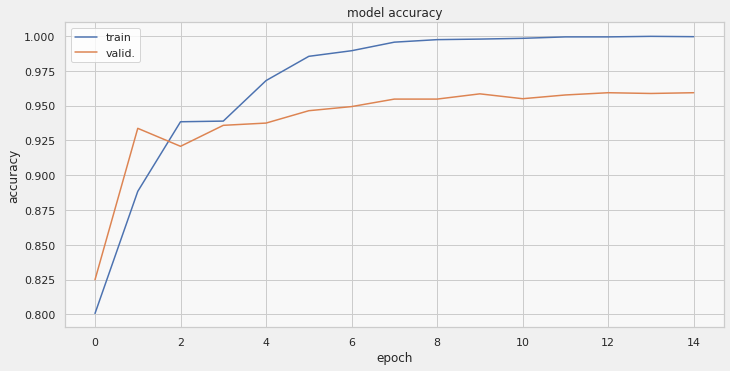

In [36]:
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    211,
)

## Test Predictions

In [37]:
X_test = ds_test.map(lambda image, idx: image)
test_probs = model.predict(X_test)
test_pred = np.argmax(test_probs, axis=-1)

test_idx_ds = ds_test.map(lambda image, idnum: idnum).unbatch()
test_idx = next(iter(test_idx_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

submission = pd.DataFrame(test_idx, columns=['id'])
submission['label'] = test_pred
submission.to_csv('submission.csv', index=False)
display(submission.head(10))

id  label
0  252d840db     67
1  1c4736dea     28
2  c37a6f3e9     83
3  00e4f514e    103
4  59d1b6146     70
5  8d808a07b     53
6  aeb67eefb     52
7  53cfc6586     29
8  aaa580243     82
9  d907ca7c0     13